Date last modified: 2018 - 03 - 14

In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [6]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from numpy.linalg import inv
import math
from dateutil.parser import parse
import matplotlib.pyplot as plt
from dateutil.parser import parse

from scipy import stats

In [7]:
train_df = pd.read_csv("../input/train_1.csv")

page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]

train_df = page_details.merge(train_df, how="inner", left_index=True, right_index=True)
enWiki_df = train_df.groupby('project').get_group('en.wikipedia.org').groupby('agent').get_group('all-agents')

In [8]:
def findIndex(name):
    count,__ = train_df.shape
    for i in range(count):
        if train_df.iloc[i,3] == name:
            return i

In [9]:
import pickle
def save_obj(obj, name ):
    with open('./../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def hasNaN(u):
    row, col = u.shape
    for i in range(col):
        if np.isnan(u[0,i]):
            return True
    return False

        
bestWeeklySine = load_obj("sineall")

Input Processing

In [127]:
pageNo = 19
print 'Page Name: ', enWiki_df.iloc[pageNo,3]
num = findIndex(enWiki_df.iloc[pageNo,3])

signal = np.matrix(train_df.iloc[num,4:].values)
if hasNaN(signal):
     raise Exception('Some nan values found !')
ignorelen = 0                                      # Useful if you don't want to touch the testing data at all

if ignorelen == 0:
    u = signal[:]
else:
    u = signal[:-ignorelen]
_, length = signal.shape
siglen = length - ignorelen

minimum, maximum = signal.min(), signal.max()

RESCALED_MAX = 5
ROUND = 5
powerRaise = round( math.log(RESCALED_MAX, max(train_df.iloc[num,4:].values)), ROUND)

print "Min:",minimum , "Max:", maximum
print "Power to be raised:", powerRaise

EXPECTED_MIN =2
shift =0 
mean = 0
if minimum <= EXPECTED_MIN:
    shift = EXPECTED_MIN

def inputmapping(x):
    global mean
    scaled_shifted_sig, mean = helper_inputmapping(x)
    return scaled_shifted_sig

def helper_inputmapping(x):   # maps the input to zero mean however does not save the mean to global variable        
    scaled_sig = np.power(x.astype(float)+shift,powerRaise)
    mean = np.mean(scaled_sig)
    return scaled_sig - mean, mean

def invinputmapping(y):
    return np.power(y+mean, 1/powerRaise) - shift

def sine(period, length):
    x = np.array(length)
    y = np.sin(2 * np.pi * x / period)
    return y


u = inputmapping(u.astype(float))

startIndex = bestWeeklySine[num][0]                                 # gives the starting point for sine wave with highest correlation to input signal
plt.plot(signal.T)
print "u.shape: ",u.shape

Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Min: 596.0 Max: 7066.0
Power to be raised: 0.18159
u.shape:  (1, 550)


In [78]:
try:
    load_obj("corrCoeffDict"+str(num))
except:
    print "Variable file not found. Calculating the correlation."
    print "Be patient! It takes quite a time."
    count,__ = train_df.shape
    corrCoeffDict = {}
    num = 6
    for i in range(count):
        corrCoeff,__ =  stats.pearsonr(enWiki_df.iloc[num,4:].values, train_df.iloc[i,4:].values)
        if not np.isnan(corrCoeff) and enWiki_df.iloc[num,3] != train_df.iloc[i,3]:
            if len(corrCoeffDict.keys()) <10:
                corrCoeffDict[corrCoeff] = i
            elif abs(corrCoeff) > min(np.abs(corrCoeffDict.keys())):
                if min(np.abs(corrCoeffDict.keys())) in corrCoeffDict:
                    del corrCoeffDict[ min(np.abs(corrCoeffDict.keys())) ]
                else:
                    del corrCoeffDict[-1* min(np.abs(corrCoeffDict.keys())) ]
                corrCoeffDict[corrCoeff] = i
    save_obj( corrCoeffDict,'corrCoeffDict'+ str(num))

print "Done."

Done.


In [79]:
print "Initial shape of u: ",u.shape
# plt.plot(signal.T)
u = np.reshape(u[0,:],(1,550))             # if u already has multiple helper signal delete them before adding newer ones
for _,j in corrCoeffDict.iteritems():
    u = np.vstack((u, helper_inputmapping(train_df.iloc[j,4:].values.astype(float))[0]))
#     plt.plot(train_df.iloc[j,4:].values)
    
#     print train_df.iloc[j,3]               # Page name 
#     print _,j

print "Final shape of u: ", u.shape

Initial shape of u:  (11, 550)
Final shape of u:  (11, 550)


<IPython.core.display.Javascript object>


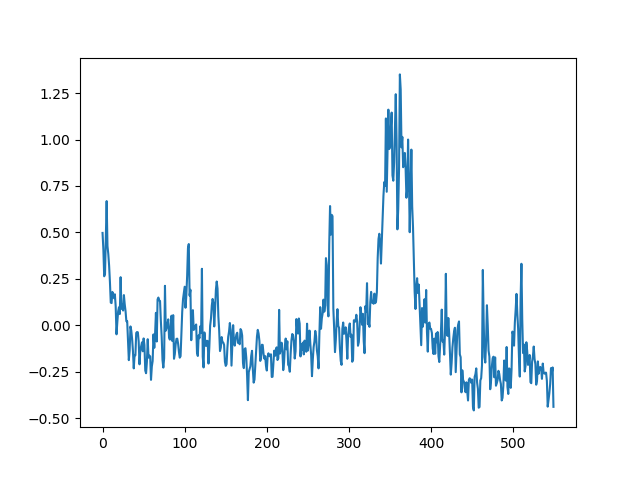

In [134]:
# plt.plot(signal.T)
for i in range(1):
    plt.plot(np.array(u)[i,:])

In [130]:
__, u_len =  u.shape 
testlen = 30                       #prediction on last 30 days.

pwin = 30
trainlen = u_len - testlen
# d = inputmapping( signal[0, pwin:trainlen].astype(float) ) 

def make_teachers():
    teachers = np.zeros((pwin,trainlen-pwin))
    for i in range(pwin):
        teachers[i,:] =  u[0, i+1:trainlen -(pwin)+i+1].astype(float)     # Assumption: u is already preprocessed (i.e logged and shifted) 
     
    return np.matrix(teachers)

d = make_teachers()

In [131]:
N = 100                                # Size of reservior

K, u_len =  u.shape                        # K: no of input signal
L,__     =  d.shape                        # L: no of output signal
np.random.seed(123)
W0    = np.random.rand(N,N) - 0.5       # The weights of synaptic links connecting the neurons
W_in0 = np.random.rand(N,K) - 0.5       # Weights for input links
                                        # The elements of W are in range of [-0.5, 0.5]
b0    = np.random.rand(N,1) - 0.5       # bias vector
W_fb0 = np.random.rand(N,L) - 0.5        # feedback weights matrix

eig_val, eig_vec = np.linalg.eig(W0)
W0 =  ( W0 / max(np.abs(eig_val)) )      # W with spectral radius of 1 unit

In [135]:
# Scaling factors
sf_W =   1                             # Scaling factor for W
sf_Win = 0.5                           # Scaling factor for W_in
sf_Wfb = 0.0000                          # zero for now
sf_b = 0                              # Scaling factor for bias
reg_coff = 0.0000001                           # Regularization cofficient
alpha = 1                              # leaky intregator neuron coffecient

W_fb = sf_Wfb* W_fb0 
W = sf_W * W0
W_in = sf_Win * W_in0
b = sf_b * b0
#===========================================================================================#
x = np.zeros((N,1))                       # State Vector of ESN
x_t = np.zeros((N,1))

S = np.zeros((trainlen-pwin,N+K));             # Contains Extended Systems States filled row-wise
S = np.matrix(S)

for t in range(trainlen - pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b)
    x = (1-alpha) * x + alpha * x_t
    S[t,:] = np.vstack((x,u[:,t])).T
    
washout = 10
S_s = S[washout:,:]
d_s = d[:,washout:]

W_out =  np.dot(np.dot(d_s, S_s), inv( np.dot(S_s.T, S_s) + reg_coff * np.eye(N+K) ) )   #correct
#===========================================================================================#

Y = np.matrix(np.zeros((L,testlen)))
y = np.matrix(np.zeros((L,1)))
for t in range(trainlen-pwin,siglen-pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b  + np.dot(W_fb, y))
    x = (1-alpha) * x + alpha * x_t
    y = np.dot(W_out, np.vstack((x,u[:,t])) )
    Y[:,t-trainlen] = y
    
# print NRMSE(invinputmapping(u[0,-30:]),invinputmapping(Y))
# plt.plot( np.array(invinputmapping(u[0,-30:]))[0].tolist())


<IPython.core.display.Javascript object>


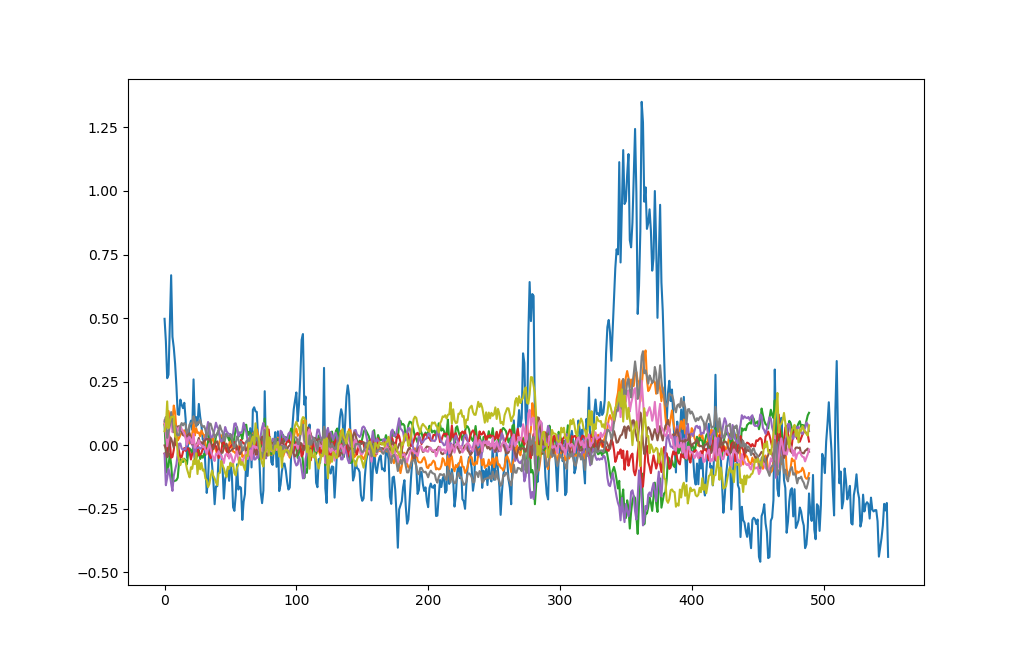

In [137]:
def plotNeuronsStates(S, neurons):
    for neuron in neurons:
        plt.plot(S[:,neuron])
        
plt.plot(np.array(u)[0,:])
plotNeuronsStates(S,[1,2,3,10,12,50,33,73])

In [16]:
# num = 20
# plt.plot( np.array(invinputmapping(Y))[num].tolist())
# plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
# print NRMSE(np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0],np.array(invinputmapping(Y))[0])

In [122]:
errSum = 0;
for i in range(pwin):
    temp = NRMSE(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
    print stats.pearsonr(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
#     print temp
    errSum+= temp
print "Average Error: ", errSum/pwin   

(0.66123973159432492, 6.9440705292506607e-05)
(0.33349710681819894, 0.071706136465210638)
(0.34399151719705517, 0.062698816076851821)
(0.37832449639610477, 0.039260143114752281)
(0.28124943279907394, 0.13217261829536034)
(0.20521955244088719, 0.27663812085504913)
(0.026107178865299379, 0.89107670638058234)
(0.07641257937143231, 0.68817522948774901)
(0.13767602817501498, 0.46814141881569571)
(0.38840496722695778, 0.033916412988216585)
(0.26203583341263015, 0.16186511046318752)
(-0.0024788531996149943, 0.98962754605545034)
(-0.047980790197084365, 0.80121141842666965)
(-0.084484270643516296, 0.65713517192501147)
(-0.057288075475056502, 0.76364806662098039)
(-0.013838221704912989, 0.94214215297825255)
(-0.028238953061902699, 0.88224161411665647)
(0.11307617341253849, 0.55188351079210762)
(0.095620511089129945, 0.61522084752951445)
(0.34269186675171426, 0.063763714051413692)
(0.44636157903083101, 0.013416442278468877)
(0.32230256610727059, 0.082385972894257309)
(0.32462198225036581, 0.08007

NRMSE Error:  1.65152770208
(0.07641257937143231, 0.68817522948774901)


<IPython.core.display.Javascript object>


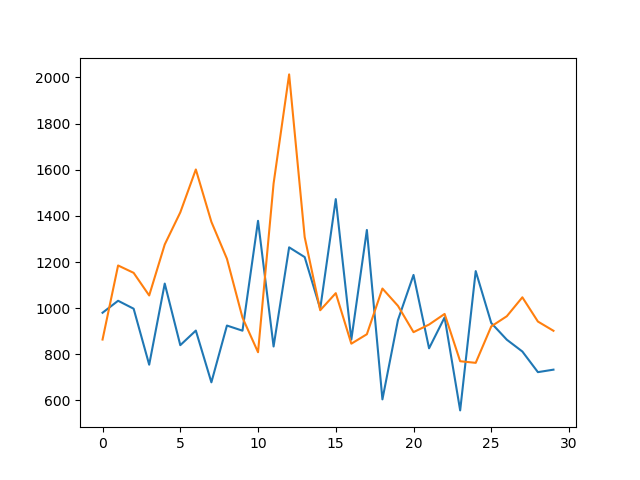

In [120]:
num =7
print "NRMSE Error: ", NRMSE(np.array(invinputmapping(Y))[num],  np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0])
print stats.pearsonr( np.array(invinputmapping(Y))[num].tolist(),np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
plt.plot( np.array(invinputmapping(Y))[num].tolist())
plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())


In [ ]:
plt.plot(df.iloc[signal_no,1:].values)

In [ ]:
plt.plot(df.iloc[signal_no,1:].values)

In [100]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( d - np.mean(d) **2)
    NRMSE = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return NRMSE  

In [102]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    # for 1 dimensional d and p
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( np.power( (d  - np.mean(d)), 2) )
#     print 'var = ' ,var
    nrmse = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return nrmse

